In [1]:
from datetime import datetime
from constants.CONSTANTS import *
from aia_image_api import imageparam_getter as ipg
import numpy as np
from datetime import timedelta 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

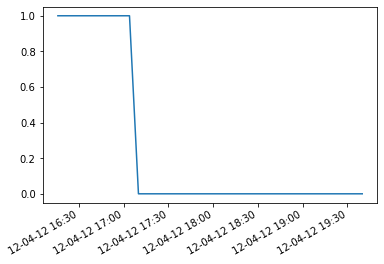

In [6]:
def QualityChecker_single(dt_start,days2check,aia_wave,image_size,param_id,DatesDF):
    dt=dt_start=datetime.strptime(dt_start, '%Y-%m-%dT%H:%M:%S')
    dt_stop = dt_start+timedelta(days=days2check) 
    while dt<dt_stop:
        if (DatesDF['date']==dt).any():
            dt=dt+timedelta(minutes=6)
            continue
        xml = ipg.get_aia_imageparam_xml(dt, aia_wave)
        res = ipg.convert_param_xml_to_ndarray(xml)
        entropyValues=res[:,:,(int(param_id)-1):int(param_id)].reshape(64, 64)
        if dt==dt_start:
            lastcorrectmat=entropyValues
            dt=dt+timedelta(minutes=6)
            continue
        diffmat_from_last_correct=np.absolute(np.subtract(lastcorrectmat, entropyValues))
        rot_diffmat_from_last_correct=np.absolute(np.subtract(lastcorrectmat, np.rot90(entropyValues)))
        diffsum=np.sum(diffmat_from_last_correct)
        rot_diffsum=np.sum(rot_diffmat_from_last_correct)
        if rot_diffsum<diffsum:
            DatesDF.loc[len(DatesDF)]=[dt,diffsum,0,aia_wave,image_size,param_id]
            lastcorrectmat=np.rot90(entropyValues)
        else:
            DatesDF.loc[len(DatesDF)]=[dt,diffsum,1,aia_wave,image_size,param_id]
            lastcorrectmat=entropyValues

        dt=dt+timedelta(minutes=6)  
    return DatesDF

def QualityChecker(dt_start,days2check,aia_wave_array,image_size_array,param_id_array):
    '''
    dt_start should be string in format YYYY-MM-DDTHH:MM:SS example: 2012-04-12T16:10:00
    days2check represents how many days from start date you want to check quality example: 0.2, 1, 5, 30
    '''
    DatesDF=pd.DataFrame(columns=['date','diff','good','aia_wave','image_size','param_id'])
    for aia_wave in aia_wave_array:
        for image_size in image_size_array:
            for param_id in param_id_array:
                DatesDF=QualityChecker_single(dt_start,days2check,aia_wave,image_size,param_id,DatesDF)
    DatesDFplot=DatesDF[['date','good']].sort_values(by=['date']).reset_index(drop=True)
    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    plt.plot(DatesDFplot['date'],DatesDFplot['good'])
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    plt.show()
    
    improper_images_DatesDF=DatesDF[DatesDF['good']==0]
    improper_images_DatesDF['date'].to_excel("ImproperImagesDates.xlsx",header=False,index=False)
    return DatesDF

DatesDF=QualityChecker('2012-04-12T16:10:00',0.15,[AIA_WAVE.AIA_171],[IMAGE_SIZE.P2000],['1'])

## To get the images to check the results

### To get the images for a range of time

In [97]:
def getImagesinTimeRange(dt_start,days2check,aia_wave,image_size,param_id):
    dt=dt_start = datetime.strptime(dt_start, '%Y-%m-%dT%H:%M:%S')
    dt_stop = dt_start + timedelta(days=days2check)
    while dt < dt_stop:
        heatmap = ipg.get_aia_imageparam_jpeg(dt, aia_wave, image_size, param_id)
        heatmap.save('SunImages/' + str(dt) + '.png')
        dt = dt + timedelta(minutes=6)

dt_start='2012-04-12T16:10:00'
days2check=2.25
aia_wave = AIA_WAVE.AIA_171
image_size = IMAGE_SIZE.P2000
param_id = '1'

getImagesinTimeRange(dt_start,days2check,aia_wave,image_size,param_id)

### To get the image of a particular timestamp

In [86]:
def getImage(dt,aia_wave,image_size,param_id):
    dt = datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S')
    heatmap = ipg.get_aia_imageparam_jpeg(dt, aia_wave, image_size, param_id)
    heatmap.save('SunImages/' + str(dt) + '.png')

dt='2012-04-14T15:04:00'
aia_wave = AIA_WAVE.AIA_171
image_size = IMAGE_SIZE.P2000
param_id = '1'

getImage(dt,aia_wave,image_size,param_id)